# Minerva Experimental Pipeline

One of Minerva’s core features are regarding reproducibility and experiment management. In this notebook, we will show how to use the `Experiment` class run and manage experiments in a structured way. 
This class implements a Minerva pipeline that allows you to run experiments in a reproducible manner, while also providing a convenient interface for managing and analyzing the results.


We will cover the following topics:

1. **The ModelInstantiator Interface**: Learn how to instantiate models for supervised learning, fine-tuning, or evaluation in a consistent and modular way.

2. **Attaching Metadata**: Add informative metadata to your experiments, such as model and dataset names.

3. **Using the Experiment Class**: Understand how to run, save, and reload experiments using Minerva’s `Experiment` class, which provides a unified interface for experiment lifecycle management.

4. **Loading and Analyzing Results**: Retrieve predictions, metrics, and other results from completed experiments for analysis and comparison.


In this example, we will create a Experiment using DeepLabV3 to perform semantic segmentation on F3 dataset, based on the [Seismic Facies Segmentation Getting Started example](seismic_facies_getting_started.ipynb). You may want to check that example first to understand the dataset and the model we are using here.


## Overview of the Experiment class

The `Experiment` class is designed to manage the lifecycle of an experiment, from instantiation to execution, evaluation and result analysis. 
Thus, it can be used to:

- Train or finetune a model.
- Save checkpoints and logs, as well evaluate the model on different checkpoint states.
- Save and load experiment results and predictions.

Below is a diagram that illustrates the main components of the `Experiment` class and its interactions with other parts of the Minerva framework.
There are several parameters, some of them are optional and some others were ommited in the diagram. We show the most important ones here.

![Experiment class overview](../figures/experiment_diagram.png)

The `Experiment` class serves as a high-level interface for managing supervised learning and fine-tuning workflows in Minerva. It integrates model configuration, data handling, training logic, evaluation metrics, and result logging into a unified structure.

The class is composed of several key components:

* **experiment_name** (`str`): A unique identifier for the experiment. This is used to create a dedicated directory where logs, results, and predictions will be saved.

* **model_config** (`ModelConfig`): An instance of the `ModelConfig` class containing all necessary configuration details for model creation—whether initializing from scratch or fine-tuning.

* **data_module** (`MinervaDataModule`): An instance of the `MinervaDataModule` class that provides the training, validation, and test datasets.

* **pretrained_backbone_path** (`str`, optional): A file path to a pretrained backbone model. If provided, the model is initialized with weights from this checkpoint via `ModelInstantiator.create_model_and_load_backbone`, enabling fine-tuning. If not provided, the model is initialized from scratch using `ModelInstantiator.create_model_randomly_initialized`, which supports training from the ground up.

* **root_log_dir** (`str`, optional): The root directory where experiment-related artifacts (logs, results, checkpoints, etc.) will be saved.

* **execution_id** (`str` or `int`, optional): A unique identifier for the specific execution run of the experiment. Useful for distinguishing between multiple runs of the same experiment.

* **checkpoint_metrics** (`List[Dict]`, optional): A list of dictionaries defining model checkpointing behavior. It will be used to create lightning `ModelCheckpoint` callbacks. Each dictionary must include:

  * `"monitor"`: The metric to monitor (e.g., `"val_loss"`).
  * `"mode"`: `"min"` or `"max"`, indicating whether the monitored metric should be minimized or maximized.
  * `"filename"`: The filename for saving the checkpoint.
  * If `"monitor"` is `None`, the checkpoint will correspond to the final model state. Defaults to `None`.

* **max_epochs** (`int`, optional): The maximum number of training epochs. Training will terminate once this limit is reached.

* **evaluation_metrics** (`Dict[str, torchmetrics.Metric]`, optional): A dictionary of evaluation metrics applied globally across the entire dataset. Each metric is computed on the aggregate predictions.

* **per_sample_evaluation_metrics** (`Dict[str, torchmetrics.Metric]`, optional): A dictionary of metrics evaluated individually per sample. Useful for tasks requiring per-instance performance monitoring.

* **save_predictions** (`bool`, default=`True`): Whether to save the predictions generated during evaluation. Saved predictions will be stored in the experiment directory.

* **save_results** (`bool`, default=`True`): If enabled, the final results will be saved to the log directory.

* **add_last_checkpoint** (`bool`, default=`True`): If `True`, the last model checkpoint (i.e., the final state after training) will be included in the checkpoint list, even if it's not associated with a specific monitored metric.


Minerva's `Experiment` class is built to support both training from scratch and fine-tuning workflows. By toggling the `pretrained_backbone_path`, users can seamlessly switch between initializing models with pretrained weights or random parameters. This flexibility makes the class adaptable to a wide range of machine learning scenarios.

### The `ModelInstantiator` Interface

The `ModelInstantiator` interface is a central component in the Minerva Experimental Pipeline for enabling flexible and consistent model creation across supervised learning and fine-tuning workflows. It serves as an **abstract class for lazy model instantiation**, allowing models to be constructed only when needed, with or without pretrained components.

Minerva assumes that all models conform to the following modular design:

```
+-------------------------------+
|     Model (LightningModule)   |
|                               |
|     +-----------------+       |
|     |    Backbone     |       |   --> Feature extractor
|     +-----------------+       |
|             |                 |
|             v                 |
|        +----------+           |
|        |   Head   |           |   --> Task-specific layers
|        +----------+           |
+-------------------------------+
```

This structure separates the **backbone** (typically a pretrained feature extractor) from the **head** (task-specific layers), facilitating easy reuse and fine-tuning.


The `ModelInstantiator` interface defines a standardized mechanism to build models across three primary scenarios:

1. **Training from scratch**: Both the backbone and head are randomly initialized.
2. **Fine-tuning**: A pretrained backbone is loaded from a checkpoint, and the head is newly initialized for the target task.
3. **Inference/Evaluation**: The full model (backbone and head) is loaded from a previously saved checkpoint.

To support this integration, each model must implement a `ModelInstantiator` subclass that defines the following methods:

| Method                                                     | Parameters                         | Description                                                                                                                                             |
| ---------------------------------------------------------- | ---------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `create_model_randomly_initialized()`                      | None                               | Instantiates a model with both backbone and head **randomly initialized**. Used when training from scratch.                                             |
| `create_model_and_load_backbone(backbone_checkpoint_path)` | `backbone_checkpoint_path` (`str`) | Instantiates a model for **fine-tuning**. Loads the backbone from the specified checkpoint and attaches a **new head** initialized for the target task. |
| `load_model_from_checkpoint(checkpoint_path)`              | `checkpoint_path` (`str`)          | Loads the **entire model** (both backbone and head) from a checkpoint. Typically used for **evaluation, inference, or resuming training**.              |


> **NOTE**: If `pretrained_backbone_path` is to `Experiment` constructor, the `create_model_and_load_backbone` method will be called with the provided path as the `backbone_checkpoint_path` argument. Else the `create_model_randomly_initialized` method will be called.


### The `ModelConfig` Class

The `ModelConfig` class serves as a high-level configuration object for managing model setup within the Minerva Experimental Pipeline. Instead of passing a model instance directly, the `Experiment` class expects a `ModelConfig` instance that encapsulates both **model creation logic** and **descriptive metadata**.

`ModelConfig` includes two key components:

1. **ModelInstantiator**: Responsible for **creating the model instance** in different scenarios—training from scratch, fine-tuning with a pretrained backbone, or loading from a checkpoint for evaluation. This interface enables lazy and flexible model instantiation, as described in the previous section.

2. **ModelInformation**: A metadata container that holds descriptive information about the model. This includes the model's name, type, version, and any other relevant details that may be useful for logging, tracking, or analysis.

In `ModelInformation`, the only required field is `name`, which serves as the unique identifier for the model. All other fields are optional and can be used to provide additional context. While optional in the `Experiment` class, subclasses may require certain fields in `ModelInformation` to be set, depending on the specific logic of the training or evaluation workflow.


### Experiment Logging

The `Experiment` class provides a structured way to save and log various artifacts related to the experiment. 
In general, for each execution of the experiment the following directory structure is created:

```
root_log_dir/
└── experiment_name/
   └── data_module.name
        └── model_information.name
           └── execution_id/
              ├── metrics.csv
              ├── checkpoints/
              ├── predictions/
              └── results/
``` 

- **metrics.csv**: A CSV file containing the metrics collected during training. This file serves as a summary of the experiment's performance, logged with Lightning logger (e.g., training loss, etc.). It can be used for further analysis or visualization.
- **checkpoints/**: Contains model checkpoints saved during training. Each checkpoint corresponds to a specific state of the model, allowing for easy resumption or evaluation.
- **predictions/**: Contains the predictions generated by the model during evaluation. This allows for easy access to the model's output for further analysis.
- **results/**: Stores the final results of the experiment, including metrics and evaluation scores. This provides a summary of the experiment's performance.


## Example: Using the `Experiment` Class for Seismic Facies Segmentation

In this example, we'll demonstrate how to use the `Experiment` class in Minerva to perform semantic segmentation on the F3 dataset using the DeepLabV3 model. This builds upon the [Seismic Facies Segmentation Getting Started example](seismic_facies_getting_started.ipynb), so it's recommended to review that notebook first to understand the dataset and model components being reused here.

In general, this notebook encapsulates the process of training a DeepLabV3 model on the F3 dataset from [Seismic Facies Segmentation Getting Started example](seismic_facies_getting_started.ipynb) into a structured pipeline using the `Experiment` class.

The notebook is organized into the following sections:

1. **Data Preparation**: Using the `MinervaDataModule` from the previous example
2. **Model Setup**: Creating the `ModelInstantiator` and `ModelConfig` classes
3. **Experiment Definition**: Building the custom `Experiment` class
4. **Training and Evaluate Model**: Running the experiment
5. **Managing Results and Lifecycle**: Saving and loading results, and also experiment lifecycle management
6. **Cleanup**: Cleaning up the experiment directory

In [6]:
from pathlib import Path
import numpy as np
import lightning as L
import torch
from torchmetrics import JaccardIndex
import matplotlib.pyplot as plt

from minerva.data.readers.patched_array_reader import NumpyArrayReader
from minerva.transforms.transform import Repeat, Squeeze
from minerva.data.datasets.base import SimpleDataset
from minerva.models.nets.image.deeplabv3 import DeepLabV3
from minerva.models.loaders import FromPretrained
from minerva.utils.typing import PathLike
from minerva.data.data_modules.base import MinervaDataModule
from minerva.pipelines.experiment import ModelConfig, ModelInstantiator, ModelInformation, Experiment

### 1. Data Preparation

In this section, we will create a `MinervaDataModule` for the F3 dataset, as we did in the [Seismic Facies Segmentation Getting Started example](seismic_facies_getting_started.ipynb), using data from the F3 dataset.

Thus, it will:
1. Create the train data and labels readers and create the train dataset.
2. Create the test data and labels readers and create the test dataset.
3. Create a `MinervaDataModule` instance with the train and test datasets.

In [2]:
# 1. Create the train data and labels readers and create the train dataset.

root_data_dir = Path("datasets/f3/data/")

# ----- TRAIN DATA AND LABEL READERS -----
train_data_reader = NumpyArrayReader(
    data=root_data_dir / "train" / "train_seismic.npy",
    data_shape=(1, 701, 255),
)

train_labels_reader = NumpyArrayReader(
    data=root_data_dir / "train" / "train_labels.npy",
    data_shape=(1, 701, 255),
)

# ----- TRAIN DATASET -----
train_dataset = SimpleDataset(
    readers=[
        train_data_reader,  # 1st reader is the data
        train_labels_reader # 2nd reader is the labels
    ],
    transforms=[
        Repeat(axis=0, n_repetitions=3),  # Transforms to first reader (data)
        None                              # Transforms to second reader (labels)
    ],
)

print(train_dataset)

           📂 SimpleDataset Information            
📌 Dataset Type: SimpleDataset
   └── Reader 0: NumpyArrayReader(samples=401, shape=(1, 701, 255), dtype=float64)
   │     └── Transform: Repeat(axis=0, n_repetitions=3)
   └── Reader 1: NumpyArrayReader(samples=401, shape=(1, 701, 255), dtype=uint8)
   │     └── Transform: None
   │
   └── Total Readers: 2


In [3]:
# 2. Create the test data and labels readers and create the test dataset.

# ----- TEST DATA AND LABEL READERS -----
test_data_reader = NumpyArrayReader(
    data=root_data_dir / "test_once" / "test1_seismic.npy",
    data_shape=(1, 701, 255),
)

test_labels_reader = NumpyArrayReader(
    data=root_data_dir / "test_once" / "test1_labels.npy",
    data_shape=(1, 701, 255),
)

# ----- TEST DATASET -----
test_dataset = SimpleDataset(
    readers=[test_data_reader, test_labels_reader],
    transforms=[Repeat(axis=0, n_repetitions=3), Squeeze(0)],
)

print(test_dataset)

           📂 SimpleDataset Information            
📌 Dataset Type: SimpleDataset
   └── Reader 0: NumpyArrayReader(samples=200, shape=(1, 701, 255), dtype=float64)
   │     └── Transform: Repeat(axis=0, n_repetitions=3)
   └── Reader 1: NumpyArrayReader(samples=200, shape=(1, 701, 255), dtype=uint8)
   │     └── Transform: Squeeze(axis=0)
   │
   └── Total Readers: 2


In [14]:
# 3. Create a `MinervaDataModule` instance with the train and test datasets.

# ---- DATA MODULE -----
data_module = MinervaDataModule(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    batch_size=16,
    num_workers=4,
    additional_train_dataloader_kwargs={"drop_last": True},
    name="F3_Dataset"
)

print(data_module)

                    🆔 F3_Dataset
└── Predict Split: test
📂 Datasets:
   ├── Train Dataset:
   │      ==================================================
   │                 📂 SimpleDataset Information            
   │      ==================================================
   │      📌 Dataset Type: SimpleDataset
   │         └── Reader 0: NumpyArrayReader(samples=401, shape=(1, 701, 255), dtype=float64)
   │         │     └── Transform: Repeat(axis=0, n_repetitions=3)
   │         └── Reader 1: NumpyArrayReader(samples=401, shape=(1, 701, 255), dtype=uint8)
   │         │     └── Transform: None
   │         │
   │         └── Total Readers: 2
   │      ==================================================
   ├── Val Dataset:
   │      None
   └── Test Dataset:
                     📂 SimpleDataset Information            
          📌 Dataset Type: SimpleDataset
             └── Reader 0: NumpyArrayReader(samples=200, shape=(1, 701, 255), dtype=float64)
             │     └── Transform: Rep

### 2. Model Setup

We will use DeepLabV3 as the model for semantic segmentation. As `Experiment` class requires a `ModelConfig` instance, we will create a custom `ModelInstantiator` and `ModelConfig` classes to encapsulate the model creation logic and metadata.

Thus, we will:
1. Create a custom `ModelInstantiator` class that implements the `create_model_randomly_initialized` and `load_model_from_checkpoint` methods. We will not implement the `create_model_and_load_backbone` method, as we will not use a pretrained backbone in this example.
2. Create a `ModelInformation` instance to hold metadata about the model, such as its name and type.
3. Create a custom `ModelConfig` class using the `ModelInstantiator` and `ModelInformation` instances. This class will be passed to the `Experiment` class to create the model.

#### ModelInstantiator for DeepLabV3

Let's define a custom `ModelInstantiator` class for the DeepLabV3 architecture. This class will implement the methods: `create_model_randomly_initialized`, and `load_model_from_checkpoint`. These methods allow the model to be either initialized from scratch or loaded from a checkpoint.

Instantiators are designed to be reusable across multiple experiments that use the same model architecture. However, it’s common to define different instantiators when the model’s backbone is loaded in different ways, for example:

* One `ModelInstantiator` for a DeepLabV3 model pretrained with **SimCLR**
* Another for a DeepLabV3 model pretrained with **BYOL**

This distinction is necessary whenever the loading process for the backbone differs, for instance, if the parameter names or checkpoint structures do not align. In such cases, a custom loading strategy is required, which is encapsulated in the corresponding instantiator.

Let's implement a very simple `ModelInstantiator` for the DeepLabV3 model, that can be customizable with different number of classes.

In [15]:
class DeepLabV3_Instantiator(ModelInstantiator):
    def __init__(self, num_classes: int):
        super().__init__()
        self.num_classes = num_classes
        
    def create_model_randomly_initialized(self) -> L.LightningModule:
        # Create a DeepLabV3 model with random initialization
        model = DeepLabV3(num_classes=self.num_classes)
        return model
    
    def create_model_and_load_backbone(self, backbone_checkpoint_path):
        # Does nothing, just create a DeepLabV3 model with random initialization
        return self.create_model_randomly_initialized()
    
    def load_model_from_checkpoint(self, checkpoint_path: PathLike) -> L.LightningModule:
        # Load whole DeepLabV3 model from a checkpoint 
        model = DeepLabV3(num_classes=self.num_classes)
        model = FromPretrained(model, ckpt_path=checkpoint_path, strict=False)
        return model
    

# Ok, now we can create a instance of the `DeepLabV3_Instantiator` class.
instantiator = DeepLabV3_Instantiator(num_classes=6)
print(instantiator)

#### Creating the ModelConfig

Once we have the `ModelInstantiator`, we can create a `ModelConfig` instance. This instance will encapsulate the model creation logic and metadata, and will be passed to the `Experiment` class to create the model.

In [16]:
information = ModelInformation(
    name="deeplabv3-crossentropy-adam", # Name of the model (required)
    backbone_name="resnet50",           # Backbone name (optional)
    task_type="semantic_segmentation",  # Task type (optional)
    num_classes=6
)

print(information)

ModelInformation(name='deeplabv3-crossentropy-adam', backbone_name='resnet50', task_type='semantic_segmentation', input_shape=None, output_shape=None, num_classes=6, return_logits=None)


In [17]:
model_config = ModelConfig(
    instantiator=instantiator,          # Model instantiator (required)
    information=information,            # Model information (required)
)
print(model_config)

ModelConfig
├── Instantiator: DeepLabV3_Instantiator
├── name: deeplabv3-crossentropy-adam
├── backbone_name: resnet50
├── task_type: semantic_segmentation
├── input_shape: None
├── output_shape: None
├── num_classes: 6
└── return_logits: None


### 3. Experiment Definition

Once data module and model configuration are set up, we can define the `Experiment` class. The experiment will be named as `f3_deeplabv3_experiment`, and will use the `ModelConfig` instance created in the previous step.

We also use the following parameters:
- `max_epochs`: Set to 10 for quick testing.
- `root_log_dir`: Set to `./logs` to store the experiment logs.
- `execution_id`: Set to `0` for the first execution.
- `checkpoint_metrics`: no custom checkpoint metrics are defined, as we will not use them in this example.
- `evaluation_metrics`: we calculate the mean Intersection over Union (mIoU) metric for the evaluation.
- `accelerator`: Set to `gpu` to use GPU acceleration (used to create Lightning trainer).
- `devices`: Set to `1` to use one GPU (used to create Lightning trainer).
- `seed`: Set to `42` for reproducibility.
- `save_predictions`: Set to `True` to save predictions for this example.
- `add_last_checkpoint`: Set to `True` to add the last checkpoint to the list of checkpoints.
- `save_results`: Set to `True` to save the results of the experiment.

In [19]:
experiment = Experiment(
    experiment_name="f3_deeplabv3",  # Name of the experiment (required)
    model_config=model_config,       # Model configuration (required)
    data_module=data_module,         # Data module (required)
    root_log_dir=Path("logs"),  # Root log directory (optional)
    execution_id=0,
    checkpoint_metrics=None,
    accelerator="gpu",  # Accelerator (optional)
    devices=1,          # Number of devices (optional)
    max_epochs=10,
    evaluation_metrics={"mIoU": JaccardIndex(num_classes=6, task="multiclass")},
    seed=42,
    save_predictions=True,
    save_results=True,
    add_last_checkpoint=True
)

print(experiment)

                          🚀 Experiment: f3_deeplabv3 🚀

🛠 Execution Details
   ├── Execution ID: 0
   ├── Log Dir: /workspaces/minerva-workspace/Minerva-Dev/docs/notebooks/logs/f3_deeplabv3/F3_Dataset/deeplabv3-crossentropy-adam/0
   ├── Seed: 42
   ├── Accelerator: gpu
   ├── Devices: 1
   ├── Max Epochs: 10
   ├── Train Batches: all
   ├── Val Batches: all
   └── Test Batches: all

🧠 Model Information
   ├── Model Name: deeplabv3-crossentropy-adam
   ├── Pretrained Backbone: FROM SCRATCH
   ├── Input Shape: None
   ├── Output Shape: None
   └── Num Classes: 6

📂 Dataset Information
                          🆔 F3_Dataset
      └── Predict Split: test
      📂 Datasets:
         ├── Train Dataset:
         │      ==================================================
         │                 📂 SimpleDataset Information            
         │      ==================================================
         │      📌 Dataset Type: SimpleDataset
         │         └── Reader 0: NumpyArrayRead

### 4. Training and Evaluate Model

Once the `Experiment` class is defined, we can run the experiment using the `run` method. 
The `run` method is the main entry point for executing the experiment. It handles the entire lifecycle of the experiment, including training, evaluation, and result logging.

The `run` method have a `task` parameter that controls the type of task to be performed. It can be:
- `fit`: To train the model
- `evaluate`: To evaluate the model
- `fit-evaluate`: To train and evaluate the model (both steps above, for convenience)

for `fit` and `evaluate` tasks a lightning trainer object will be created using the parameters passed to the `Experiment` constructor (accelerator, devices, etc.).

In general, the `fit` method will:
- Setup directories, logger, and callbacks
- Create the model randomly initialized (if `pretrained_backbone_path` is not provided) or create the model and load the backbone (if `pretrained_backbone_path` is provided)
- Create the trainer and fit the model using `trainer.fit()` method
- Save the model checkpoints and logs
- Save the metrics to a CSV file

The `evaluate` method will:
- Setup directories and evaluation metrics
- Create the model using the `load_model_from_checkpoint` method
- Create the trainer and perform predictions using `trainer.predict()` method
- Save the predictions to a file
- Evaluate the model using the evaluation metrics, based on the predictions made
- Save the results to a file

> **NOTE**: If multiple `checkpoint_metrics` are defined, the `evaluate` method will be called for each checkpoint. The results will be saved in separate files, one for each checkpoint. You may control this behaviour by passing `ckpts_to_evaluate` parameter to the `experiment.run()` method,specifying only the checkpoint to be evaluated. By default, all checkpoints will be evaluated.

We going to use the `fit-evaluate` task for this example, so we will train and evaluate the model in one step. The result is a dictionary with the following keys, one for each checkpoint:

```python
{
    "predictions_path": predictions_file,   # Path to the predictions file
    "results_path": results_filename,       # Path to the results file
    "results_path_per_sample": results_filename_per_sample, # Path to the per sample results file
    "results": results,                 # Pandas dataframe with the results for each metric
    "results_per_sample": per_sample_results, # Pandas dataframe with the results for each sample
}
```

In [20]:
result = experiment.run(task="fit-evaluate")
print(f"Result: {list(result.keys())}")

** Seed set to: 42 **


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/vscode/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



                           Experiment: f3_deeplabv3                             
🧠 Model
   ├── Name: deeplabv3-crossentropy-adam
   ├── Finetune: No
   ├── Resumed From: Beginning
   ├── Expected Input Shape: None
   ├── Expected Output Shape: None
   ├── Total Params: 41,684,014
   └── Trainable Params: 41,684,014 (100.00%)

📊 Dataset
   ├── Train Samples: 401
   |   ├── Input Shape: shape=(3, 701, 255)
   |   └── Label Shape: shape=(1, 701, 255)
   └── Validation Dataset: None

💾 Logging & Checkpoints
   ├── Log Dir: /workspaces/minerva-workspace/Minerva-Dev/docs/notebooks/logs/f3_deeplabv3/F3_Dataset/deeplabv3-crossentropy-adam/0
   ├── Metrics Path: logs/f3_deeplabv3/F3_Dataset/deeplabv3-crossentropy-adam/0/metrics.csv
   └── Checkpoints Dir: logs/f3_deeplabv3/F3_Dataset/deeplabv3-crossentropy-adam/0/checkpoints
       └── Files: last.ckpt

⚙️ Trainer Config
   ├── Max Epochs: 10
   ├── Train Batches: None
   ├── Accelerator: gpu
   ├── Strategy: auto
   ├── Devices: 1
   ├── Num


  | Name     | Type                    | Params | Mode 
-------------------------------------------------------------
0 | backbone | DeepLabV3Backbone       | 25.6 M | train
1 | fc       | DeepLabV3PredictionHead | 16.1 M | train
2 | loss_fn  | CrossEntropyLoss        | 0      | train
-------------------------------------------------------------
41.7 M    Trainable params
0         Non-trainable params
41.7 M    Total params
166.736   Total estimated model params size (MB)
186       Modules in train mode
0         Modules in eval mode
/home/vscode/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 25/25 [00:11<00:00,  2.09it/s, v_num=0, train_loss=0.0285]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 25/25 [00:21<00:00,  1.16it/s, v_num=0, train_loss=0.0285]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model loaded from logs/f3_deeplabv3/F3_Dataset/deeplabv3-crossentropy-adam/0/checkpoints/last.ckpt

                     Evaluation: f3_deeplabv3 (last.ckpt)                       
💾 Checkpoint
   ├── Checkpoint Path: logs/f3_deeplabv3/F3_Dataset/deeplabv3-crossentropy-adam/0/checkpoints/last.ckpt
   └── Predictions Path: logs/f3_deeplabv3/F3_Dataset/deeplabv3-crossentropy-adam/0/predictions/last.npy

📊 Dataset
   ├── Predict Samples: 200
   ├── Input: shape=(3, 701, 255)
   └── Label: shape=(701, 255)

📈 Evaluation Metrics
   ├── mIoU: MulticlassJaccardIndex

⚙️ Trainer Config
   ├── Max Epochs: 10
   ├── Predict Batches: None
   ├── Accelerator: gpu
   ├── Strategy: auto
   ├── Devices: 1
   ├── Num Nodes: 1
   └── Seed: 42
Predicting DataLoader 0: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s]
Predictions saved to logs/f3_deeplabv3/F3_Dataset/deeplabv3-crossentropy-adam/0/predictions/last.npy


Computing metrics: 100%|██████████| 13/13 [00:00<00:00, 13.14it/s]


Results saved to logs/f3_deeplabv3/F3_Dataset/deeplabv3-crossentropy-adam/0/results/last.csv
No per-sample evaluation metrics provided. Skipping per-sample evaluation.
Checkpoint last evaluated!
Result: ['last']


We can get the results from the last checkpoint by using the `results` key. The results is a pandas dataframe with one column for each metric and one row for each sample.

In [29]:
ckpt_name = "last"
result[ckpt_name]["results"]

,sample,mIoU
0,all,0.691551


### 5. Managing Results and Lifecycle

Once the experiment is completed, we can use the `Experiment` class to manage the results and lifecycle of the experiment.

The following methods and properties are available:
- `checkpoint_paths` (property): Returns the paths to the model checkpoints saved during training. This is a dictionary with the checkpoint name as key and the path as value.
- `training_metrics_path` (property): Returns the path to the training metrics CSV file.
- `training_metrics` (property): Returns the training metrics as a Pandas dataframe.
- `prediction_paths` (property): Returns the paths to the predictions files saved during evaluation, one for each checkpoint. This is a dictionary with the checkpoint name as key and the path as value.
- `load_predictions_of_ckpt` (method): Loads the predictions for a specific checkpoint. It expects the checkpoint name as argument. Names can be achieved using the `checkpoint_paths` property.
- `results_paths` (property): Returns the paths to the results files saved during evaluation, one for each checkpoint. This is a dictionary with the checkpoint name as key and the path as value.
- `load_results_of_ckpt` (method): Loads the results for a specific checkpoint. It expects the checkpoint name as argument. Names can be achieved using the `results_paths` property.
- `status` (property): Returns information and status of the experiment in a dictionary format. The `state` key indicates whether the experiment is: "evaluated", "predicted", "executed", or "not executed". The "not executed" means the experiment was not run yet. The "executed" means the experiment was run, but not evaluated yet. The "predicted" means the experiment was run and predictions were made, but not evaluated yet. The "evaluated" means the experiment was run and evaluated. This state is based on the files saved in the experiment directory. Thus, if you opt to not save predictions or results, the status will be "executed" even if the experiment was run and evaluated once.
- `cleanup` (method): Cleans up the experiment directory, removing all files and subdirectories.

In [30]:
# We can check the experiment state using status funtion

experiment.status

{'experiment_name': 'f3_deeplabv3',
 'log_dir': PosixPath('/workspaces/minerva-workspace/Minerva-Dev/docs/notebooks/logs/f3_deeplabv3/F3_Dataset/deeplabv3-crossentropy-adam/0'),
 'checkpoints': {'last': PosixPath('logs/f3_deeplabv3/F3_Dataset/deeplabv3-crossentropy-adam/0/checkpoints/last.ckpt')},
 'training_metrics': PosixPath('logs/f3_deeplabv3/F3_Dataset/deeplabv3-crossentropy-adam/0/metrics.csv'),
 'prediction_paths': {'last': PosixPath('logs/f3_deeplabv3/F3_Dataset/deeplabv3-crossentropy-adam/0/predictions/last.npy')},
 'results_paths': {'last': PosixPath('logs/f3_deeplabv3/F3_Dataset/deeplabv3-crossentropy-adam/0/results/last.csv')},
 'state': 'evaluated'}

We can print the directory structure of the experiment directory to see the files and subdirectories created during the experiment.

In [51]:
def print_tree(root: Path, prefix: str = ""):
    if not root.is_dir():
        print(f"{root} is not a directory.")
        return

    entries = sorted(root.iterdir(), key=lambda x: (x.is_file(), x.name.lower()))
    for i, entry in enumerate(entries):
        connector = "└── " if i == len(entries) - 1 else "├── "
        print(prefix + connector + entry.name)
        if entry.is_dir():
            extension = "    " if i == len(entries) - 1 else "│   "
            print_tree(entry, prefix + extension)


print(experiment.root_log_dir)
print_tree(experiment.root_log_dir)

logs
└── f3_deeplabv3
    └── F3_Dataset
        └── deeplabv3-crossentropy-adam
            └── 0
                ├── checkpoints
                │   └── last.ckpt
                ├── predictions
                │   └── last.npy
                ├── results
                │   └── last.csv
                └── metrics.csv


We can check the evaluated metrics from a specific checkpoint using the `load_results_of_ckpt` method.It is equivalent from the results returned by the `run` method (using `fit-evaluate` task).

In [ ]:
results = experiment.load_results_of_ckpt("last")
results

,sample,mIoU
0,all,0.691551


We can check the training metrics using the `training_metrics` property. It returns a pandas dataframe with the training metrics for each epoch, based on lightning CSV Logger.

In [34]:
training_metrics = experiment.training_metrics
training_metrics

,epoch,step,train_loss
0,0,24,0.331632
1,1,49,0.085685
2,2,74,0.060906
3,3,99,0.051845
4,4,124,0.049144
5,5,149,0.041069
6,6,174,0.036828
7,7,199,0.034012
8,8,224,0.030449
9,9,249,0.028480


We can plot the training metrics using matplotlib or any other plotting library. 

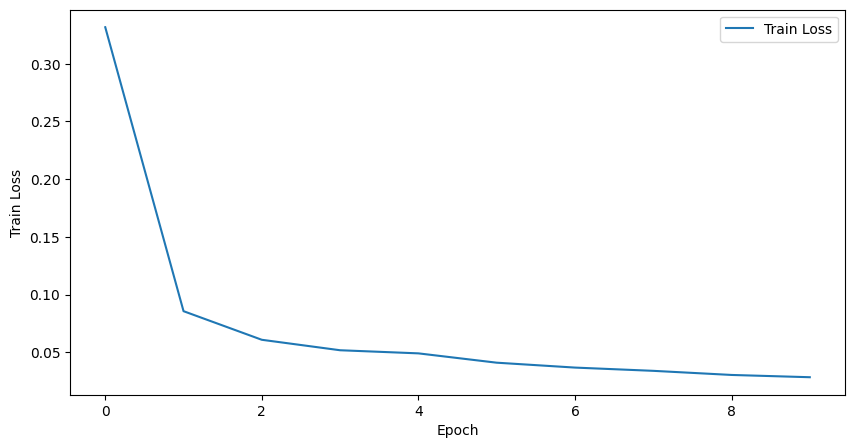

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(training_metrics["epoch"], training_metrics["train_loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.legend()
plt.show()

If saved, we can also obtain the predictions using the `load_predictions_of_ckpt` method. It return the logits predictions for the specific checkpoint. The predictions are saved in a numpy array format, with (N, L, H, W) shape, where N is the number of samples, L is the number of classes (logits), H is the height and W is the width of the image. 

Let's compare the predictions with the ground truth labels using matplotlib. 

In [37]:
index = 100

# Get the test data and labels
test_labels = experiment.data_module.test_dataset[index][1]
test_labels.shape

(701, 255)

In [40]:
predictions = experiment.load_predictions_of_ckpt("last")
# Calculcate the predictions from logits
predictions = predictions[index].argmax(axis=0)
predictions.shape

(701, 255)

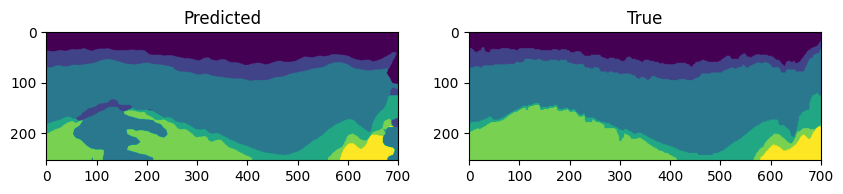

In [41]:
# Lets visualize the test data, labels and predictions

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(predictions.T)
axes[0].set_title("Predicted")
axes[1].imshow(test_labels.T)
axes[1].set_title("True")
plt.show()

### 6. Cleanup

Finally, we can clean up the experiment directory using the `cleanup` method. This will remove all files and subdirectories created during the experiment. This is useful to free up disk space and remove unnecessary files.

In [52]:
experiment.cleanup()

Experiment at '/workspaces/minerva-workspace/Minerva-Dev/docs/notebooks/logs/f3_deeplabv3/F3_Dataset/deeplabv3-crossentropy-adam/0' cleaned up.


We can print the directory structure of the experiment directory to check if files were removed.

In [53]:
print(experiment.root_log_dir)
print_tree(experiment.root_log_dir)

logs
└── f3_deeplabv3
    └── F3_Dataset
        └── deeplabv3-crossentropy-adam
